
# Introductory Overview of PyMC

Note: This text is partly based on the [PeerJ CS publication on PyMC](https://peerj.com/articles/cs-55/) by John Salvatier, Thomas V. Wiecki, and Christopher Fonnesbeck.



## Abstract

Probabilistic Programming allows for automatic Bayesian inference on user-defined probabilistic models. Gradient-based algorithms for Markov chain Monte Carlo (MCMC) sampling, known as Hamiltonian Monte Carlo (HMC), allow inference on increasingly complex models but requires gradient information that is often not trivial to calculate. PyMC is an open source probabilistic programming framework written in Python that uses PyTensor to compute gradients via automatic differentiation, as well as compiling probabilistic programs on-the-fly to one of a suite of computational backends for increased speed. PyMC allows for model specification in Python code, rather than in a domain-specific language, making it easy to learn, customize, and debug. This paper is a tutorial-style introduction to this software package for those already somewhat familiar with Bayesian statistics.

## Introduction

Probabilistic programming (PP) allows flexible specification of Bayesian statistical models in code. PyMC is a PP framework with an intuitive and readable, yet powerful, syntax that is close to the natural syntax statisticians use to describe models. It features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high-dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don't need to have specialized knowledge about how the algorithms work.

Probabilistic programming in Python confers a number of advantages including multi-platform compatibility, an expressive yet clean and readable syntax, easy integration with other scientific libraries, and extensibility via C, C++, Fortran or Cython. These features make it relatively straightforward to write and use custom statistical distributions, samplers and transformation functions, as required by Bayesian analysis.

While most of PyMC's user-facing features are written in pure Python, it leverages PyTensor (a fork of the Theano project) to transparently transcode models to C and compile them to machine code, thereby boosting performance. PyTensor is a library that allows expressions to be defined using generalized vector data structures called *tensors*, which are tightly integrated with the popular NumPy {class}`~numpy.ndarray` data structure, and similarly allow for broadcasting and advanced indexing, just as NumPy arrays do. PyTensor also automatically optimizes the likelihood's computational graph for speed and allows for compilation to a suite of computational backends, including Jax and Numba.

Here, we present a primer on the use of PyMC for solving general Bayesian statistical inference and prediction problems. We will first see the basics of how to use PyMC, motivated by a simple example: installation, data creation, model definition, model fitting and posterior analysis. Then we will cover two case studies and use them to show how to define and fit more sophisticated models. Finally we will discuss a couple of other useful features: custom distributions and arbitrary deterministic nodes.

## A Motivating Example: Linear Regression

To introduce model definition, fitting, and posterior analysis, we first consider a simple Bayesian linear regression model with normally-distributed priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$:

$$\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned}
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

### Generating data

We can simulate some artificial data from this model using only NumPy's {mod}`~numpy.random` module, and then use PyMC to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond to the PyMC model structure.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Here is what the simulated data look like. We use the plotting library matplotlib to visualize the data.

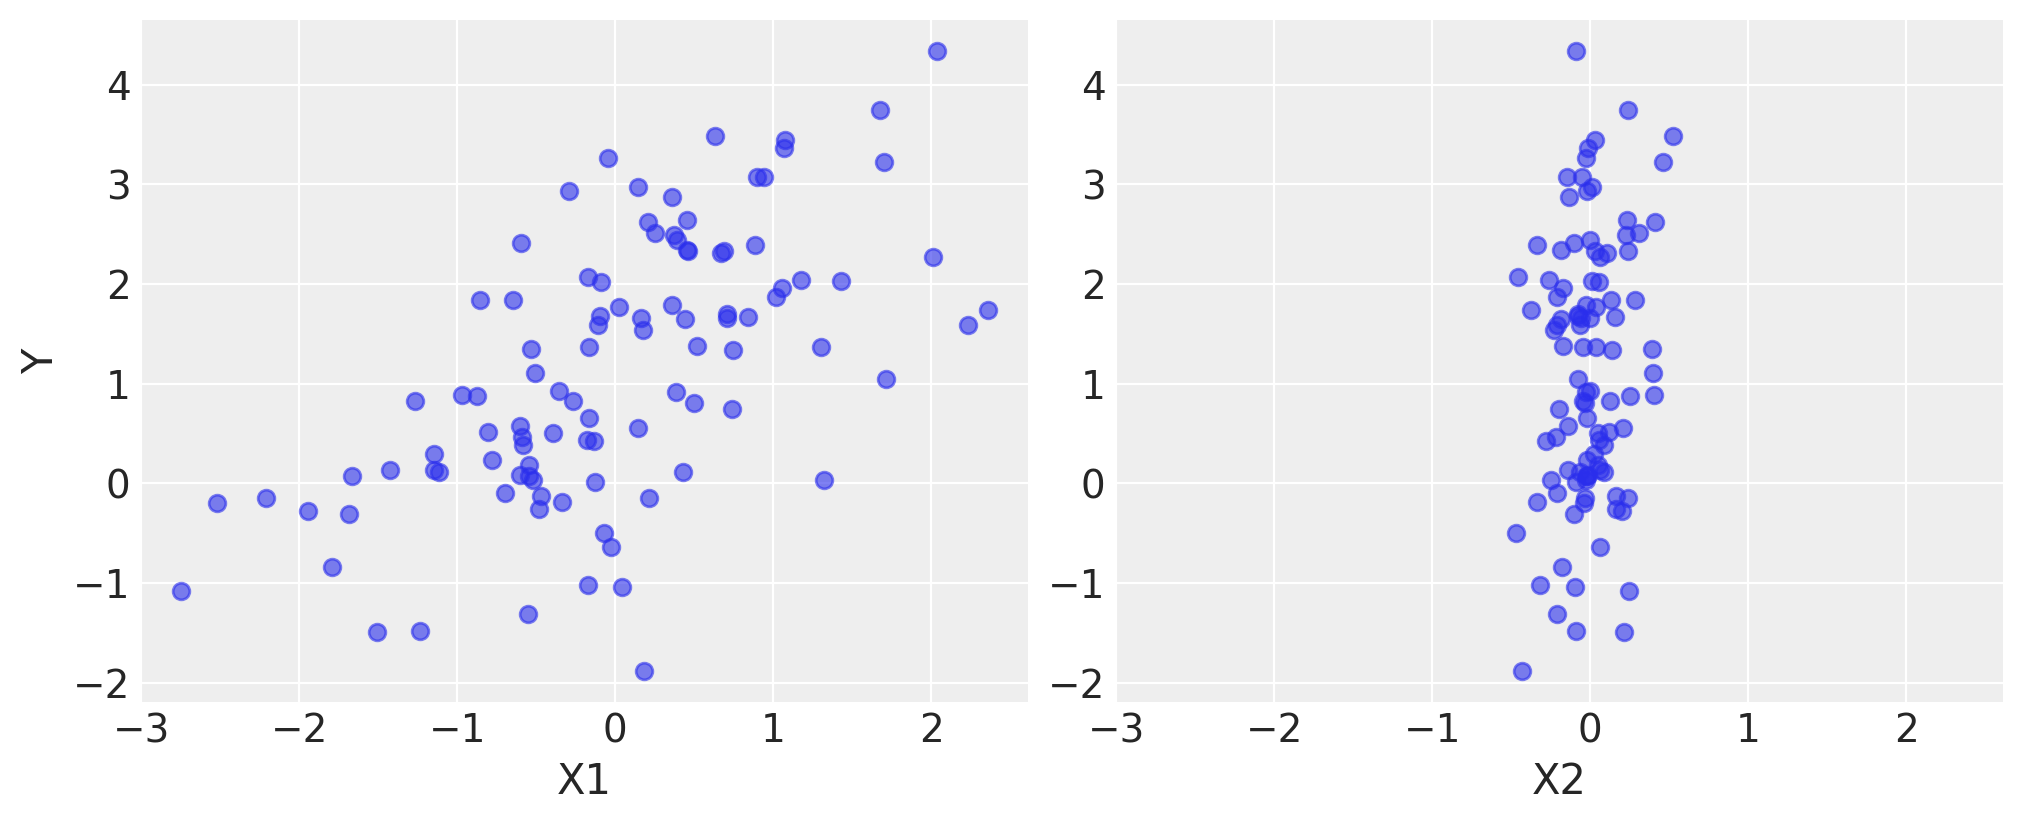

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

### Model Specification

Specifying this model in PyMC is straightforward because the syntax is similar to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above.

First, we import PyMC. We use the convention of importing it as `pm`.

In [5]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.22.0


Now we build our model, which we will present in full first, then explain each part line-by-line.

In [6]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

The first line,

```python
basic_model = pm.Model()
```

creates a new `pymc.Model` object which is a container for the model random variables.

Following instantiation of the model, the subsequent specification of the model components is performed inside a  `with` statement:

```
with basic_model:
```
This creates a *context manager*, with our `basic_model` as the context, that includes all statements until the indented block ends. This means all PyMC objects introduced in the indented code block below the `with` statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with `basic_model` right after we create them. If you try to create a new random variable without a `with model:` statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:

```python
alpha = pm.Normal('alpha', mu=0, sigma=10)
beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
sigma = pm.HalfNormal('sigma', sigma=1)
```
create **stochastic** random variables with normally-distributed prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10, and a half-normal distribution for the standard deviation of the observations, $\sigma$. These are stochastic because their values are partly determined by their parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).

We call the `pm.Normal` constructor to create a random variable to use as a normal prior. The first argument is always the *name* of the random variable, which should almost always match the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case `mu`, the mean, and `sigma`, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution's parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly-used distributions, such as `Beta`, `Exponential`, `Categorical`, `Gamma`, `Binomial` and many others, are available in PyMC.

The `beta` variable has an additional `shape` argument to denote it as a vector-valued parameter of size 2. The `shape` argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer to specify an array, or a tuple to specify a multidimensional array (*e.g.* `shape=(5,7)` makes a random variable that takes on 5 by 7 matrix values).


Having defined the priors, the next statement creates the expected value `mu` of the outcomes, specifying the linear relationship:

```python
mu = alpha + beta[0]*X1 + beta[1]*X2
```
This creates a **deterministic** random variable, which implies that its value is *completely* determined by its parents' values. That is, there is no uncertainty beyond that which is inherent in the parents' values. Here, `mu` is just the sum of the intercept `alpha` and the two products of the coefficients in `beta` and the predictor variables, whatever their values may be.

PyMC random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like `sum`, `sin`, `exp` and linear algebra functions like `dot` (for inner product) and `inv` (for inverse) are also provided.

The final line of the model defines `Y_obs`, the sampling distribution of the outcomes in the dataset.

```python
Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
```

This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its `observed` argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a {class}`~numpy.ndarray` or {class}`~pandas.DataFrame` object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of `Y_obs` are not fixed values, but rather are the deterministic object `mu` and the stochastic `sigma`. This creates parent-child relationships between the likelihood and these two variables.

In [7]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


/home/enrique/anaconda3/envs/bayesian/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


The `pymc.sample` function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns an `arviz.InferenceData` object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data. Notice that `sample` generated a set of parallel chains, depending on how many compute cores are on your machine.

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

The various attributes of the `InferenceData` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. For example, we can retrieve the sampling trace from the `alpha` latent variable by using the variable name as an index to the `idata.posterior` attribute. The first dimension of the returned array is the chain index, the second dimension is the sampling index, while the later dimensions match the shape of the variable. We can see the first 5 values for the `alpha` variable in each chain as follows:

In [9]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.25987552, 1.07015112, 1.04430446, 1.28305557, 1.26852545],
       [1.10946213, 1.18721236, 1.06845834, 1.15854462, 1.07288832],
       [1.13650304, 1.24468567, 0.96975916, 1.38394708, 1.29803707],
       [1.14562377, 1.26199238, 1.26199238, 1.1911723 , 1.25460793]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40B 0 1 2 3 4

If we wanted to use the slice sampling algorithm to sample our parameters instead of NUTS (which was assigned automatically), we could have specified this as the `step` argument for `sample`.

In [10]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


/home/enrique/anaconda3/envs/bayesian/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


### Posterior analysis
`PyMC`'s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named `Arviz`. A simple posterior plot can be created using `arviz.plot_trace`.

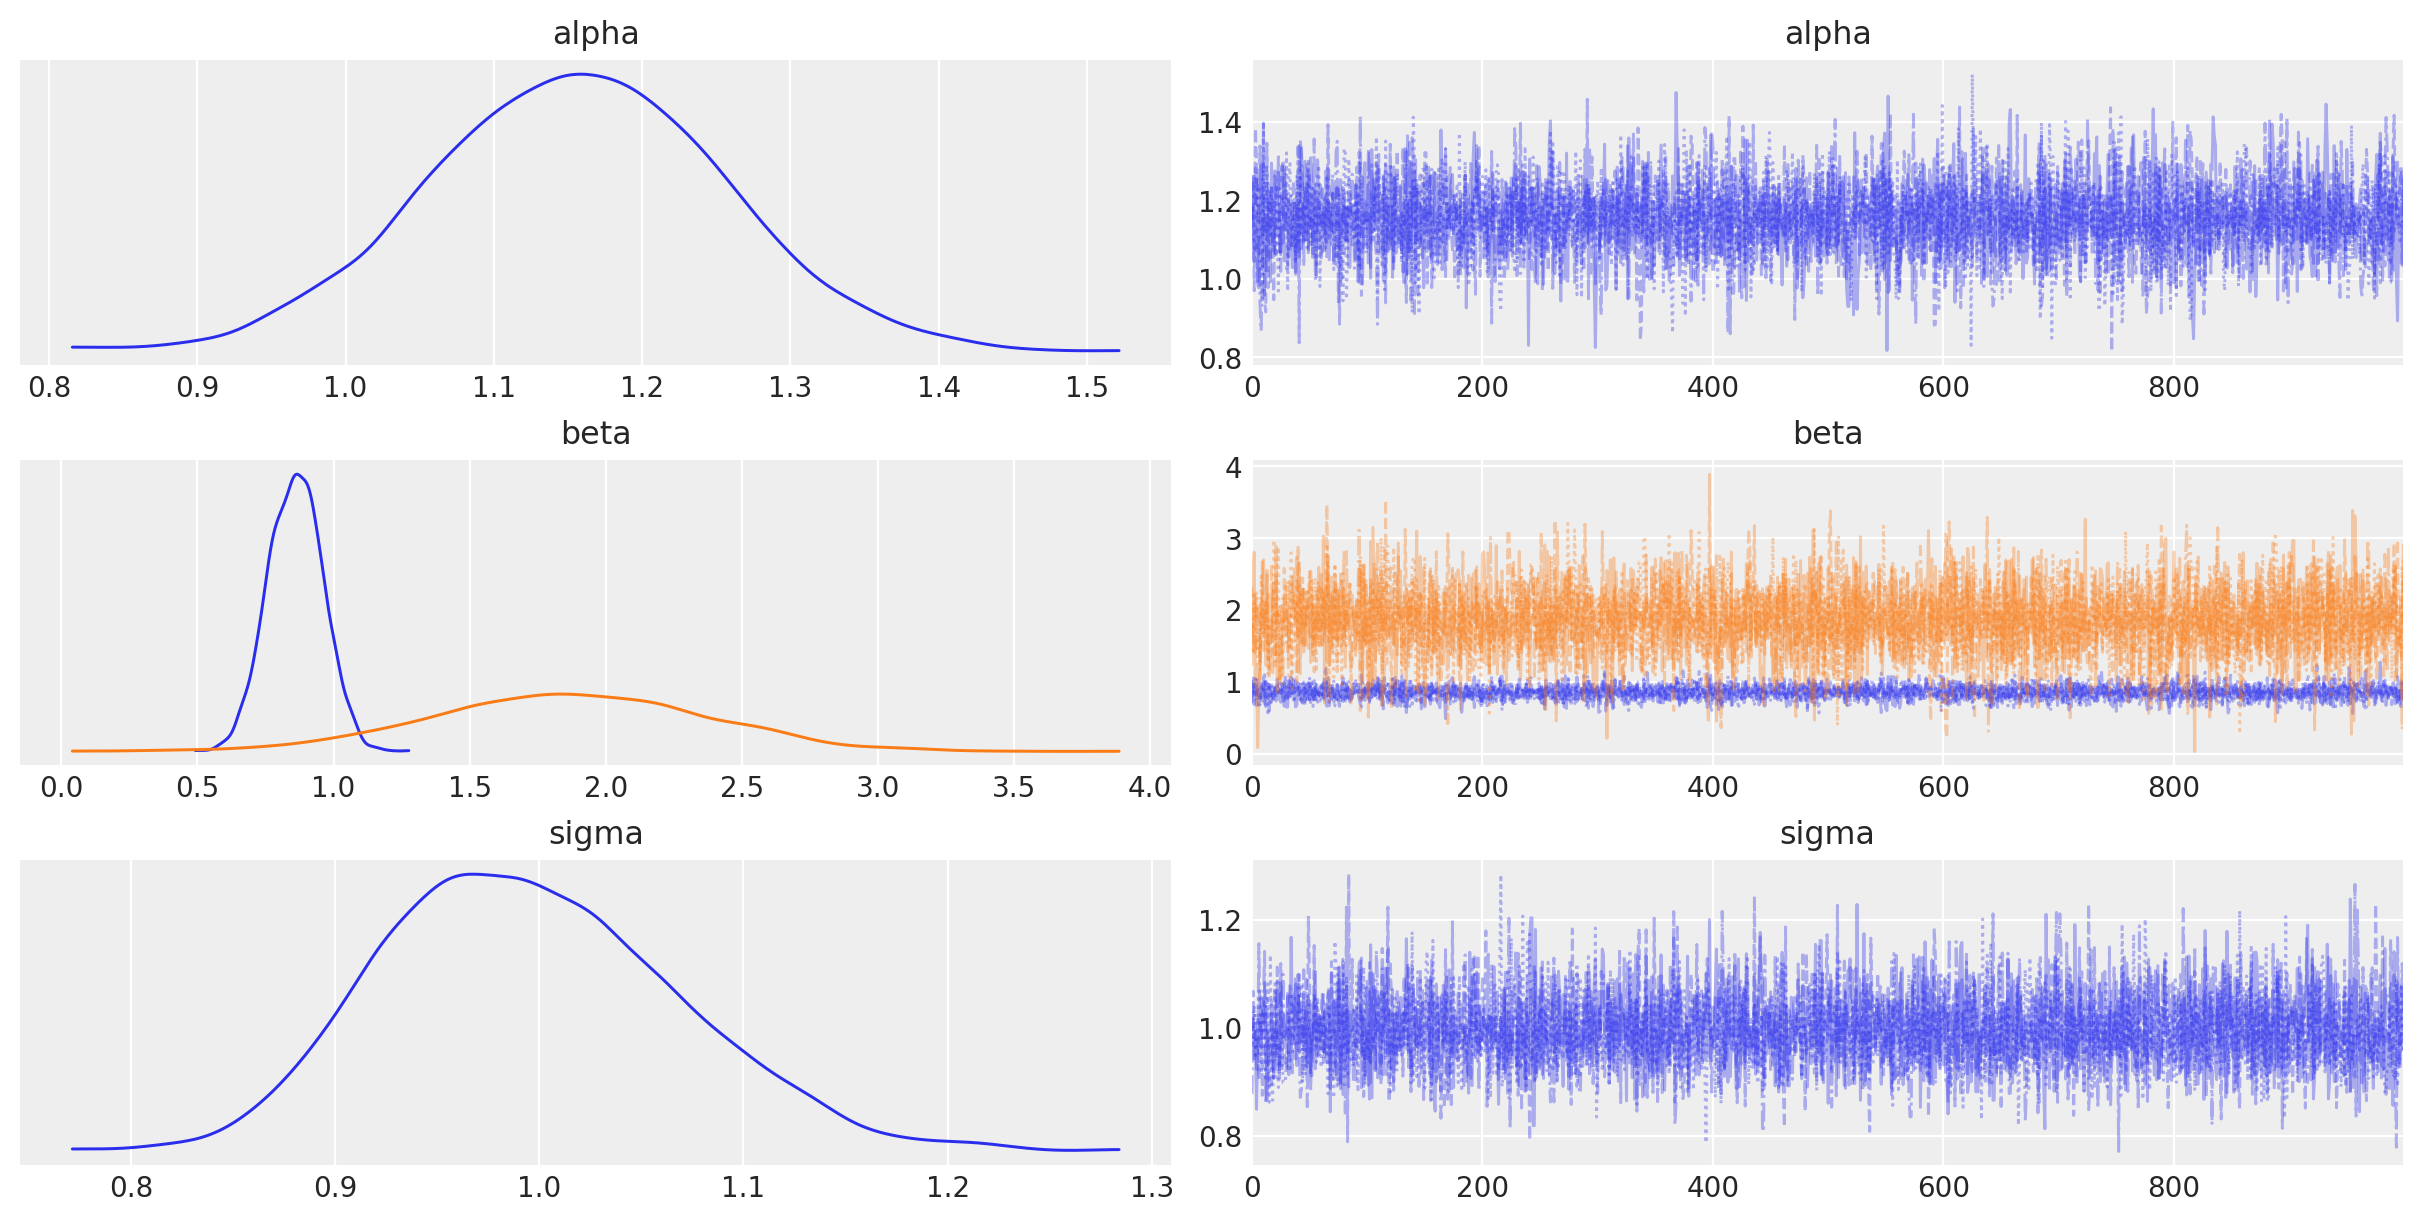

In [11]:
az.plot_trace(idata, combined=True);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The `beta` variable, being vector-valued, produces two density plots and two trace plots, corresponding to both predictor coefficients.

In addition, the `arviz.summary` function provides a text-based output of common posterior statistics:

In [12]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.16,0.10,0.97,1.35,0.00,0.00,5607.97,3000.97,1.0
beta[0],0.86,0.10,0.68,1.06,0.00,0.00,6386.56,3420.76,1.0
beta[1],1.86,0.50,0.96,2.82,0.01,0.01,5035.39,2984.28,1.0
sigma,1.00,0.07,0.88,1.14,0.00,0.00,6662.10,3676.76,1.0


## Discussion

Probabilistic programming is an emerging paradigm in statistical learning, of which Bayesian modeling is an important sub-discipline. The signature characteristics of probabilistic programming--specifying variables as probability distributions and conditioning variables on other variables and on observations--makes it a powerful tool for building models in a variety of settings, and over a range of model complexity. Accompanying the rise of probabilistic programming has been a burst of innovation in fitting methods for Bayesian models that represent notable improvement over existing MCMC methods. Yet, despite this expansion, there are few software packages available that have kept pace with the methodological innovation, and still fewer that allow non-expert users to implement models.

PyMC provides a probabilistic programming platform for quantitative researchers to implement statistical models flexibly and succinctly. A large library of statistical distributions and several pre-defined fitting algorithms allows users to focus on the scientific problem at hand, rather than the implementation details of Bayesian modeling. The choice of Python as a development language, rather than a domain-specific language, means that PyMC users are able to work interactively to build models, introspect model objects, and debug or profile their work, using a dynamic, high-level programming language that is easy to learn. The modular, object-oriented design of PyMC means that adding new fitting algorithms or other features is straightforward. In addition, PyMC comes with several features not found in most other packages, most notably Hamiltonian-based samplers as well as automatic transforms of constrained random variables which is only offered by Stan. Unlike Stan, however, PyMC supports discrete variables as well as non-gradient based sampling algorithms like Metropolis-Hastings and Slice sampling.

Development of PyMC is an ongoing effort and several features are planned for future versions. Most notably, variational inference techniques are often more efficient than MCMC sampling, at the cost of generalizability. More recently, however, black-box variational inference algorithms have been developed, such as automatic differentiation variational inference (ADVI; Kucukelbir et al., 2017). This algorithm is slated for addition to PyMC. As an open-source scientific computing toolkit, we encourage researchers developing new fitting algorithms for Bayesian models to provide reference implementations in PyMC. Since samplers can be written in pure Python code, they can be implemented generally to make them work on arbitrary PyMC models, giving authors a larger audience to put their methods into use.

## References

Bastien, F., Lamblin, P., Pascanu, R., Bergstra, J., Goodfellow, I., Bergeron, A., Bouchard, N., Warde-Farley, D., and Bengio, Y. (2012) “Theano: new features and speed improvements”. NIPS 2012 deep learning workshop.

Bergstra, J., Breuleux, O., Bastien, F., Lamblin, P., Pascanu, R., Desjardins, G., Turian, J., Warde-Farley, D., and Bengio, Y. (2010) “Theano: A CPU and GPU Math Expression Compiler”. Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX

Duane, S., Kennedy, A. D., Pendleton, B. J., and Roweth, D. (1987) “Hybrid Monte Carlo”, Physics Letters, vol. 195, pp. 216-222.

Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research, 30.

Jarrett, R.G. A note on the intervals between coal mining disasters. Biometrika, 66:191–193, 1979.

[Kucukelbir A, Dustin Tran, Ranganath R, Gelman A, and Blei DM. Automatic differentiation variational inference,  The Journal of Machine Learning Research. 18 , pp. 430-474.](http://arxiv.org/abs/1506.03431)

Lunn, D.J., Thomas, A., Best, N., and Spiegelhalter, D. (2000) WinBUGS -- a Bayesian modelling framework: concepts, structure, and extensibility. Statistics and Computing, 10:325--337.

Neal, R.M. Slice sampling. Annals of Statistics. (2003). doi:10.2307/3448413.
Patil, A., D. Huard and C.J. Fonnesbeck. (2010) PyMC: Bayesian Stochastic Modelling in Python. Journal of Statistical Software, 35(4), pp. 1-81

[Piironen, J., & Vehtari, A. (2017). Sparsity information and regularization in the horseshoe and other shrinkage priors. _Electronic Journal of Statistics_, 11(2), 5018-5051.](https://projecteuclid.org/journals/electronic-journal-of-statistics/volume-11/issue-2/Sparsity-information-and-regularization-in-the-horseshoe-and-other-shrinkage/10.1214/17-EJS1337SI.full)

[Stan Development Team. (2014). Stan: A C++ Library for Probability and Sampling, Version 2.5.0.](http://mc-stan.org)

[Vanderplas, Jake. "Frequentism and Bayesianism IV: How to be a Bayesian in Python." Pythonic Perambulations. N.p., 14 Jun 2014. Web. 27 May. 2015.](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python)


In [47]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Fri Aug 09 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.26.0

xarray: 2024.7.0

numpy     : 1.26.4
pytensor  : 2.22.1
pandas    : 2.2.1
matplotlib: 3.8.3
arviz     : 0.18.0
pymc      : 5.15.1

Watermark: 2.4.3

